In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import math
import re
from scipy.sparse import csr_matrix
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")
import os
import time
import gc
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation

## Data Loading

In [5]:
# Date not needed

netflix_df1 = pd.read_csv('combined_data_1.txt', header=None, names=['Cust_id', 'Rating'], usecols=[0,1])

netflix_df1['Rating'] = netflix_df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(netflix_df1.shape))
print('-Dataset examples-')
print(netflix_df1.iloc[::5000000, :])


# netflix_df3.head(5)

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [9]:
# Date not needed

netflix_df2 = pd.read_csv('few_samples_netflix.csv')

#netflix_df2['rating'] = netflix_df2['rating'].astype(float)

print('Dataset 2 shape: {}'.format(netflix_df2.shape))
print('-Dataset examples-')
print(netflix_df2.iloc[::5000000, :])

# netflix_df2.head(5)

Dataset 2 shape: (514358, 4)
-Dataset examples-
   Unnamed: 0  movie_id  user_id  rating
0          88         1   729846       4


In [23]:
# Date not needed

netflix_df3 = pd.read_csv('combined_data_3.txt', header=None, names=['Cust_id', 'Rating'], usecols=[0,1])

netflix_df3['Rating'] = netflix_df3['Rating'].astype(float)

print('Dataset 3 shape: {}'.format(netflix_df3.shape))
print('-Dataset examples-')
print(netflix_df3.iloc[::5000000, :])

#netflix_df3.head(5)

Dataset 3 shape: (22605786, 2)
-Dataset examples-
          Cust_id  Rating
0           9211:     NaN
5000000   2071383     4.0
10000000  2485184     5.0
15000000   765311     2.0
20000000  1260161     3.0


In [24]:
# Date not needed

netflix_df4 = pd.read_csv('combined_data_4.txt', header=None, names=['Cust_id', 'Rating'], usecols=[0,1])

netflix_df4['Rating'] = netflix_df4['Rating'].astype(float)

print('Dataset 4 shape: {}'.format(netflix_df4.shape))
print('-Dataset examples-')
print(netflix_df4.iloc[::5000000, :])

# netflix_df4.head(5)

Dataset 4 shape: (26851926, 2)
-Dataset examples-
          Cust_id  Rating
0          13368:     NaN
5000000    605496     5.0
10000000   285173     5.0
15000000   604335     5.0
20000000  2503632     5.0
25000000   470744     3.0


In [25]:
# Uncomment next two lines for full dataset with over 100 million reviews - takes a long time
#netflix_concat_frames = [netflix_df1, netflix_df2, netflix_df3, netflix_df4]
#netflix_concat_frames_df = pd.concat(netflix_concat_frames)
#df_netflix_pivot_combined_data = result.pivot(index=)
#result.head(5)

# Quarter of the Data set - commment out when not using
netflix_concat_frames = [netflix_df2]
netflix_concat_frames_df = pd.concat(netflix_concat_frames)



netflix_concat_frames_df.index = np.arange(0,len(netflix_concat_frames_df))
print('Full dataset shape: {}'.format(netflix_concat_frames_df.shape))
print('-Dataset examples-')
print(netflix_concat_frames_df.iloc[::5000000, :])

Full dataset shape: (26982302, 2)
-Dataset examples-
          Cust_id  Rating
0           4500:     NaN
5000000    485565     2.0
10000000  1155911     2.0
15000000   121369     3.0
20000000  1277779     3.0
25000000   252632     5.0


## Viewing the Data

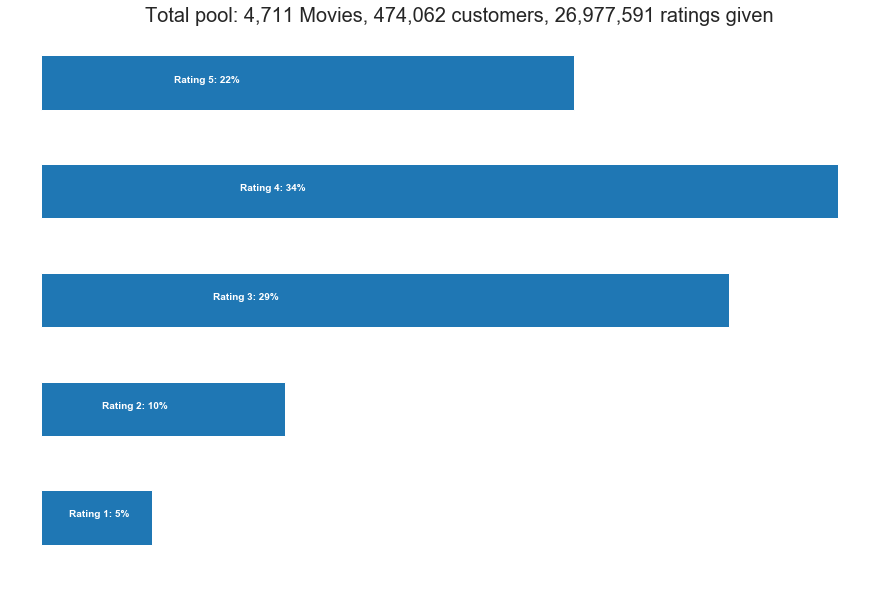

In [26]:
# View of the data 
total_pool = netflix_concat_frames_df.groupby('Rating')['Rating'].agg(['count'])

# Get movie count
movie_count = netflix_concat_frames_df.isnull().sum()[1]

cust_count = netflix_concat_frames_df['Cust_id'].nunique() - movie_count

# Get rating count
rating_count = netflix_concat_frames_df['Cust_id'].count() - movie_count

# Plot horizontal bar graph
ax = total_pool.plot(kind='barh', legend=False, figsize=(15, 10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize= 20)
plt.axis('off')

for i in range(1,6):
    ax.text(total_pool.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, total_pool.iloc[i-1][0]*100 / total_pool.sum()[0]), color='white', weight='bold')


### We can see that the ratings tend to be positive! This is probably because most unhappy customers won't take the time to rate anything - they will simply walk away. If a rating is low - it probably means the movie is very bad since someone cared enough to rate it. 

### The movie id is messy and this will probably cause computational problems - so better to fix it now!

## Data Cleaning

In [27]:
# This takes way too long - I need to find a way to cut this down and decrease processing time - my CPU usage was over 120%
# Don't run this for now 
#only do batches of ~25 million should take about 4 minutes to run 
# Create a numpy array with correct length and add the entire array as a column into the main dataframe
netflix_nan_df = pd.DataFrame(pd.isnull(netflix_concat_frames_df.Rating))
netflix_nan_df = netflix_nan_df[netflix_nan_df['Rating'] == True]
netflix_nan_df = netflix_nan_df.reset_index()

movie_np_array = []
movie_id = 1

for i, j in zip(netflix_nan_df['index'][1:], netflix_nan_df['index'][:-1]):
    # Using numpy
    temporary = np.full((1, i-j-1), movie_id)
    movie_np_array = np.append(movie_np_array, temporary)
    movie_id += 1
    
# Last record and length using numpy
last_record = np.full((1, len(netflix_concat_frames_df) - netflix_nan_df.iloc[-1,0] -1), movie_id)
movie_np_array = np.append(movie_np_array, last_record)

print('Movie numpy array: {}'.format(movie_np_array))
print('Length numpy array: {}'.format(len(movie_np_array)))

Movie numpy array: [1.000e+00 1.000e+00 1.000e+00 ... 4.711e+03 4.711e+03 4.711e+03]
Length numpy array: 26977591


In [28]:
# Configure rows so Movie_id becomes a column instead of being imbedded into a row
netflix_concat_frames_df = netflix_concat_frames_df[pd.notnull(netflix_concat_frames_df['Rating'])]

netflix_concat_frames_df['Movie_id'] = movie_np_array.astype(int)
netflix_concat_frames_df['Cust_id'] = netflix_concat_frames_df['Cust_id'].astype(int)
print('-Dataset examples-')
print(netflix_concat_frames_df.iloc[::5000000, :])

-Dataset examples-
          Cust_id  Rating  Movie_id
1         2532865     4.0         1
5000819    775559     2.0       819
10001635  2366877     4.0      1635
15002436  1579371     4.0      2436
20003268  1427824     5.0      3268
25004333   768518     4.0      4333


## Data Slicing

### The datasets are way too big! We need to find a way to limit or reduce the volume of data by improving the data quality. We need to do some benchmarking in which we reduce the same size and increase the data quality. If we remove the movies with only a few reviews this should cut down on the size of the data and also increase the quality. If we also remove customers who are not very active this should cut down on the data size and increase the quality of the data. 

### These above benchmarks should improve our efficiency - since unpopular movies and less active customers should help us improve the statistical significance of the data set.


In [29]:
# play with quartile because it may affect model accuracy

count_mean_vars = ['count', 'mean']

movie_summary_df = netflix_concat_frames_df.groupby('Movie_id')['Rating'].agg(count_mean_vars)
movie_summary_df.index = movie_summary_df.index.map(int)
movie_benchmark = round(movie_summary_df['count'].quantile(0.70), 0)
movie_list_benchmark_drop = movie_summary_df[movie_summary_df['count'] < movie_benchmark].index

print('Minimum number of times movies were reviewed: {}'.format(movie_benchmark))

customer_summary_df = netflix_concat_frames_df.groupby('Cust_id')['Rating'].agg(count_mean_vars)
customer_summary_df.index = customer_summary_df.index.map(int)
customer_benchmark = round(customer_summary_df['count'].quantile(0.70), 0)
customer_list_benchmark_drop = customer_summary_df[customer_summary_df['count'] < customer_benchmark].index

print('Minimum number of times customers reviewed movies: {}'.format(customer_benchmark))

Minimum number of times movies were reviewed: 2047.0
Minimum number of times customers reviewed movies: 57.0


In [30]:
# Let's play with this and see how we can optimize it 
# Let's see the difference in data size
print('Original Shape: {}'.format(netflix_concat_frames_df.shape))
netflix_concat_frames_df = netflix_concat_frames_df[~netflix_concat_frames_df['Movie_id'].isin(movie_list_benchmark_drop)]
netflix_concat_frames_df = netflix_concat_frames_df[~netflix_concat_frames_df['Cust_id'].isin(customer_list_benchmark_drop)]
print('After Drop Shape: {}'.format(netflix_concat_frames_df.shape))
print('-Data Examples-')
print(netflix_concat_frames_df.iloc[::5000000, :])

Original Shape: (26977591, 3)
After Drop Shape: (19379800, 3)
-Data Examples-
          Cust_id  Rating  Movie_id
3157       740327     4.0         7
7020609   1015567     2.0      1164
14032449  1091264     5.0      2287
21002493   316685     4.0      3517


### Let's put the data set into a giant matrix - as we need it for the recommender system.

In [31]:
netflix_concat_pivot = pd.pivot_table(netflix_concat_frames_df, values='Rating', index='Cust_id', columns='Movie_id')

print(netflix_concat_pivot.shape)

(143159, 1414)


## Data Mapping

### Let's load the movie mapping file

In [32]:
netflix_movie_titles_df5 = pd.read_csv('movie_titles.txt', delimiter='\t', header=None)
#netflix_movie_titles_df5.drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis =1)
netflix_movie_titles_df5 = netflix_movie_titles_df5.iloc[:, 0:3]
netflix_movie_titles_df5.columns = ['Movie_id', 'Year', 'Movie_title']
netflix_movie_titles_df5['Year'] = netflix_movie_titles_df5['Year'].astype(float) # data is dirty - has NaNs etc. - can't use int have to use float for now 
netflix_movie_titles_df5.head(5)

,Movie_id,Year,Movie_title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


# Recommendation Models

## Recommending with Collaborative Filtering

In [35]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Assign X as the original ratings dataframe and y as the Cust_id column of ratings
X = netflix_concat_frames_df.copy()
y = netflix_concat_frames_df['Cust_id']

# Split into training and test datasets, stratified along Cust-id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Import the mean_squared_error function
from sklearn.metrics import mean_squared_error

# Function computes the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define the base model to always return 3 - middle of the ratings
def baseline(Cust_id, Movie_id):
    return 3.0

# Function to compute the RMSE score obtained on the testing data set by the model
def score(collab_filter_model):
    
    # Construct a list of customer-movie tuples from the testing dataset
    id_cust_movie = zip(X_test['Cust_id'], X_test['Movie_id'])
    
    # Predict the rating for every customer - movie tuple
    y_pred = np.array([collab_filter_model(customer, movie) for (customer, movie)in id_cust_movie])
    
    # Extract the actual ratings given by the customers in the test dataset
    y_true = np.array(X_test['Rating'])
    
    # Return the final RMSE score
    return rmse(y_true, y_pred)

In [36]:
score(baseline)

1.2084806127476386

## Ratings Matrix

In [55]:
# Build the ratings matrix using the pivot_table functionality
ratings_matrix = X_train.pivot_table(values='Rating', index='Cust_id', columns='Movie_id')

ratings_matrix.head(5)

Movie_id,7,8,9,10,13,16,18,20,21,23,...,4670,4671,4676,4689,4690,4698,4705,4706,4707,4709
Cust_id,,,,,,,,,,,,,,,,,,,,,
6,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,4.0,3.0,3.0,NaN,NaN,NaN,NaN,5.0
7,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,3.0,4.0,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,4.0
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Mean

In [57]:
# Set the null / NaN ratings in the mean_ratings matrix to zero
mean_ratings = ratings_matrix.copy().fillna(0)
mean_ratings_sparse = csr_matrix(mean_ratings.values)
mean_ratings = mean_ratings_sparse

In [58]:


# Customer based collaborative filtering using mean ratings
def collab_filter_mean(Cust_id, Movie_id):
    
    
    # Check to see if Movie_id exists in ratings_matrix
    if Movie_id in ratings_matrix:
        
        # Compute the mean of all the ratings given to the movie by the customers
        mean_ratings = ratings_matrix[Movie_id].mean()
        
    else:
        
        # Default to a rating of 3.0 in the absense of any information
        mean_ratings = 3.0
        
    return mean_ratings    

In [ ]:
# runs slow

# Compute RMSE for the Mean model
score(collab_filter_mean)

## Weighted Mean

In [52]:
# Create a dummy ratings matrix with all null values imputed to 0
ratings_matrix_dummy = ratings_matrix.copy().fillna(0)

In [54]:
# Import cosine_score
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix using the dummy ratings matrix
cosine_similar = cosine_similarity(ratings_matrix_dummy, ratings_matrix_dummy)

MemoryError: 

In [51]:
# Convert into pandas dataframe
cosine_similar = pd.DataFrame(cosine_similar, index=ratings_matrix.index, columns=ratings_matrix.index)

cosine_similar.head(5)

NameError: name 'cosine_similar' is not defined

In [49]:
# User based collaborative filtering using weighted mean ratings
def collab_filter_cust_wmean(Cust_id, Movie_id):
    
    # Check to see if Movie_id exists in ratings_matrix
    if Movie_id in ratings_matrix:
        
        # Pull similarity scores for the customer in question with every other customer
        similar_scores = cosine_similar[Cust_id]
        
        # Pull the customer ratings for the movie in question
        movie_ratings = ratings_matrix[Movie_id]
        
        # Extract the indices containing NaN in the moving_ratings series
        idx = movie_ratings[movie_ratings.isnull()].index
        
        # Drop the corresponding cosine scores from the similar_scores series
        similar_scores = similar_scores.drop(idx)
        
        # Compute the final weighted mean
        wmean_rating = np.dot(similar_scores, movie_ratings) / similar_scores.sum()
        
    else:
        
        # Default to a rating of 3.0 which is the middle of ratings in the absence of any other information
        
        wmean_rating = 3.0
    
    return wmean_rating 

In [50]:
score(collab_filter_cust_wmean)

NameError: name 'cosine_similar' is not defined

## kNN  and SVD Model Based Approach

### kNN Approach

In [ ]:
# Import the required classes and methods from the surprise library - specially formulated for recommender systems
from surprise import Reader, Dataset, KNNBasic, evaluate

# Define the Reader object
reader - Reader()

# Create the datset to be used for building the collaborative filter
movie_data = Datset.load_from_df(Ratings, reader)

kNN = KNNBasic()

# Evaluate the performance in terms of RMSE
evaluate(kNN, movie_data, measures=['RMSE'])

### SVD Approach

In [ ]:
# Import SVD
from surprise import SVD

# Define the SVD algorithm object
svd = SVD()

# Evaluate the performance in terms of RMSE
evaluate(svd, movie_data, measures=['RMSE'])

### Hybrid Filtering